In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
import matplotlib.gridspec as gridspec


from BSE import market_session

import matplotlib.pyplot as plt

# Set global font sizes
plt.rcParams['font.size'] = 18  # Default font size for all text
plt.rcParams['axes.titlesize'] = 18  # Font size for plot titles
plt.rcParams['axes.labelsize'] = 18  # Font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 18  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 18  # Font size for y tick labels
plt.rcParams['legend.fontsize'] = 18  # Font size for legend
plt.rcParams['figure.titlesize'] = 18  # Font size for figure titles


In [4]:
# Setting file path locations 
id = 'new_trader_chart_0_'
#id = 'heston_model_session_0_'
file_path = id + 'LOB_frames.csv'
prices = id + "tape.csv"
volumes = id + 'blotters.csv'
balances = id + 'avg_balance.csv'


In [5]:
tape_df = pd.read_csv(prices, header=None, names=['Type', 'Time', 'Price'])

In [6]:
# Initialize lists
time_list, bid_total_quantity, bid_prices, bid_quantities = [], [], [], []
ask_total_quantity, ask_prices, ask_quantities = [], [], []

# Read the file and parse the data
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        
        # Split the line using "Bid:" and "Ask:" as delimiters
        parts = re.split(r'(Bid:|Ask:)', line)
        time_stamp = float(parts[0].strip().rstrip(','))
        
        # Parse bid and ask data
        bid_data, ask_data = [], []
        for i in range(1, len(parts) - 1, 2):
            values = [int(val) for val in parts[i + 1].strip().split(',') if val.strip().isdigit()]
            if parts[i] == 'Bid:':
                bid_data = values
            elif parts[i] == 'Ask:':
                ask_data = values
        
        # Extract and assign bid data
        if bid_data:
            bid_total_quantity.append(bid_data[0])
            bid_prices.append(bid_data[1::2])  # Take prices at odd indices
            bid_quantities.append(bid_data[2::2])  # Take quantities at even indices
        else:
            bid_total_quantity.append(None)
            bid_prices.append([])
            bid_quantities.append([])
        
        # Extract and assign ask data
        if ask_data:
            ask_total_quantity.append(ask_data[0])
            ask_prices.append(ask_data[1::2])  # Take prices at odd indices
            ask_quantities.append(ask_data[2::2])  # Take quantities at even indices
        else:
            ask_total_quantity.append(None)
            ask_prices.append([])
            ask_quantities.append([])

        # Store the timestamp
        time_list.append(time_stamp)

# Create the expanded DataFrame
expanded_df = pd.DataFrame({
    'Time': time_list,
    'Bid Total Quantity': bid_total_quantity,
    'Bid Prices': [', '.join(map(str, prices)) for prices in bid_prices],
    'Bid Quantities': [', '.join(map(str, quantities)) for quantities in bid_quantities],
    'Ask Total Quantity': ask_total_quantity,
    'Ask Prices': [', '.join(map(str, prices)) for prices in ask_prices],
    'Ask Quantities': [', '.join(map(str, quantities)) for quantities in ask_quantities]
})

# Display the expanded DataFrame
expanded_df.head(5)


,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities
0,0.000,0,,,0,,
1,0.325,0,,,1,281,1
2,0.625,1,11,1,1,281,1
3,0.720,1,11,1,2,"281, 367","1, 1"
4,0.940,2,"11, 148","1, 1",2,"281, 367","1, 1"


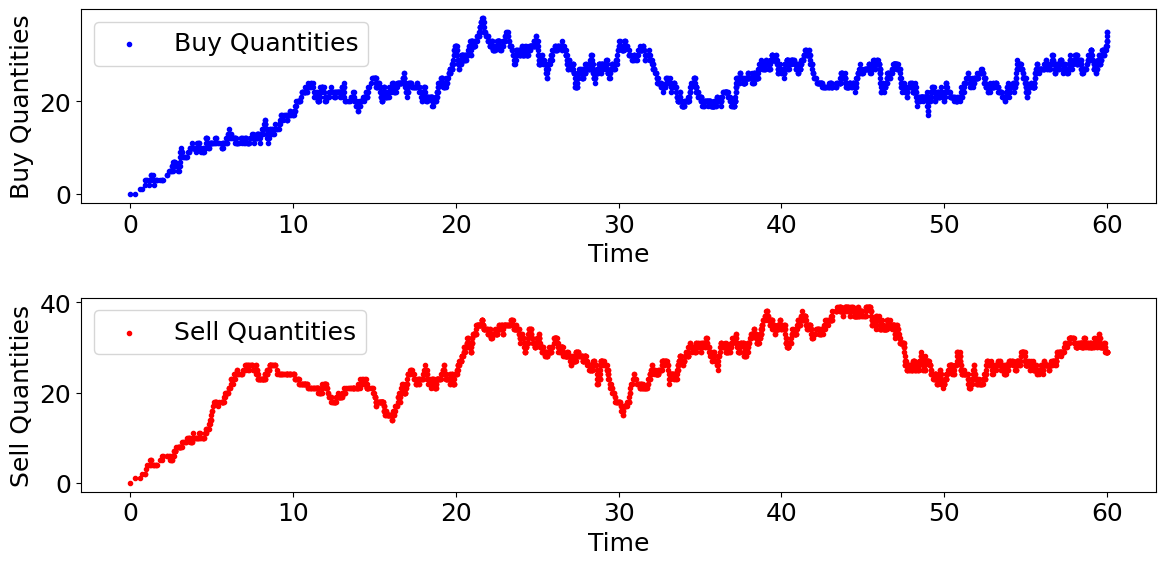

In [7]:
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# Plot buy quantities
axs[0].scatter(time_list, bid_total_quantity, label='Buy Quantities', color='blue', marker = '.')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Buy Quantities')
axs[0].legend()
#axs[0].grid(True)

# Plot sell quantities
axs[1].scatter(time_list, ask_total_quantity, label='Sell Quantities', color='red', marker = '.')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Sell Quantities')
axs[1].legend()
#axs[1].grid(True)

# Show the plots
#axs[0].set_xlim(20,120)
#axs[1].set_xlim(20,120)
#axs[0].set_ylim(50,120)
#axs[1].set_ylim(50,120)
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Time')

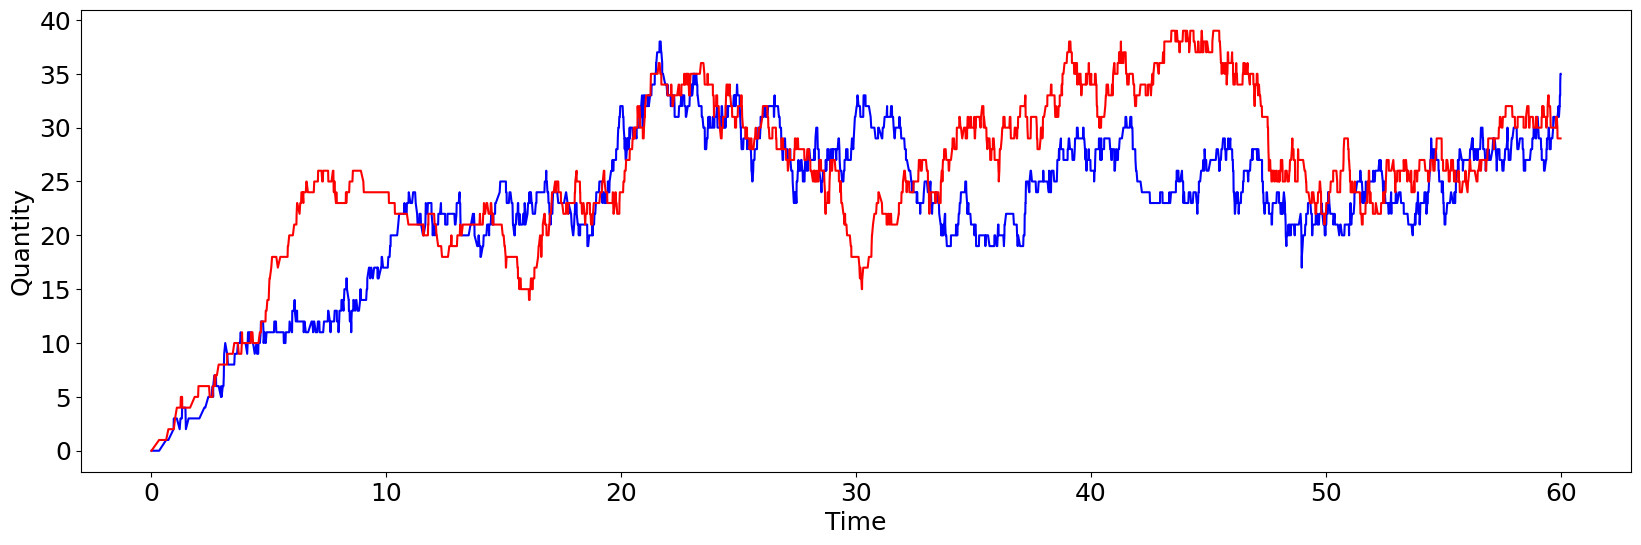

In [8]:
fig, axs = plt.subplots(figsize=(20, 6))
plt.plot(time_list, bid_total_quantity, label='Buy Quantities', color='blue')
plt.plot(time_list, ask_total_quantity, label='Sell Quantities', color='red')
plt.ylabel('Quantity')
plt.xlabel('Time')

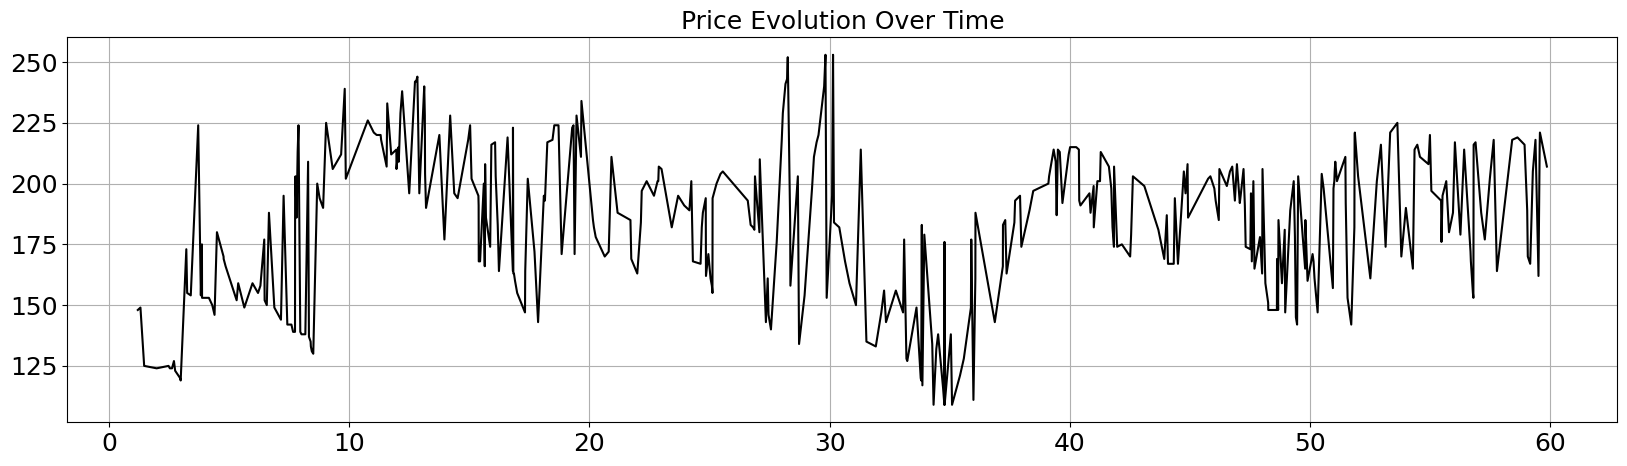

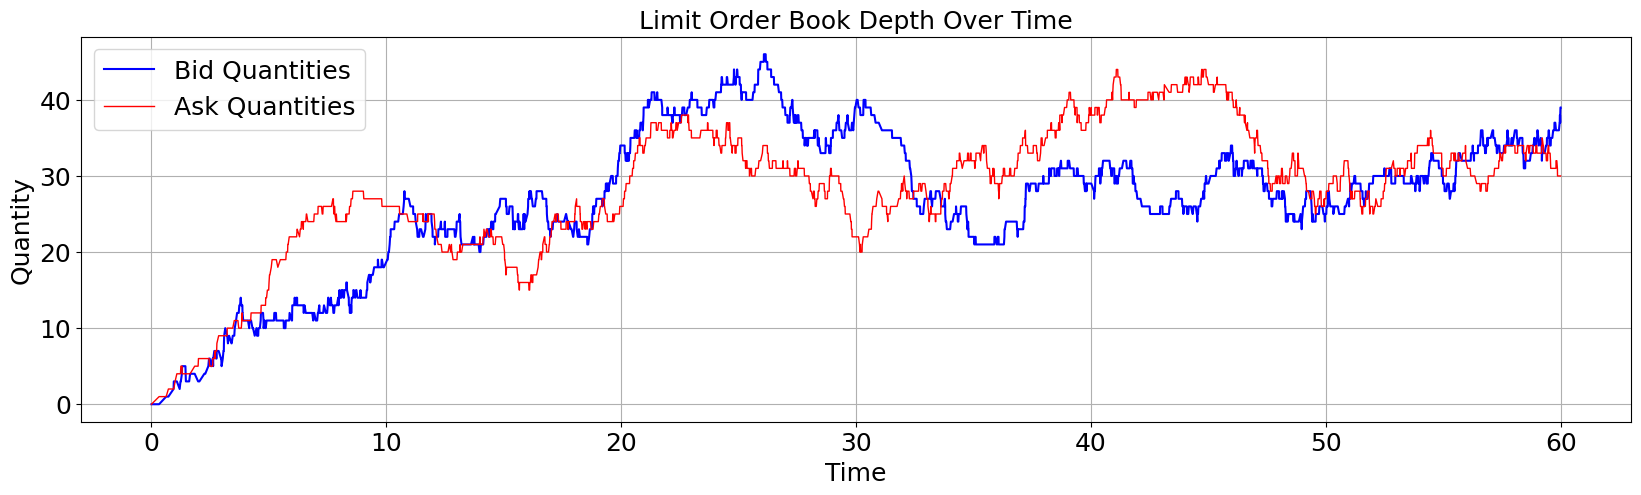

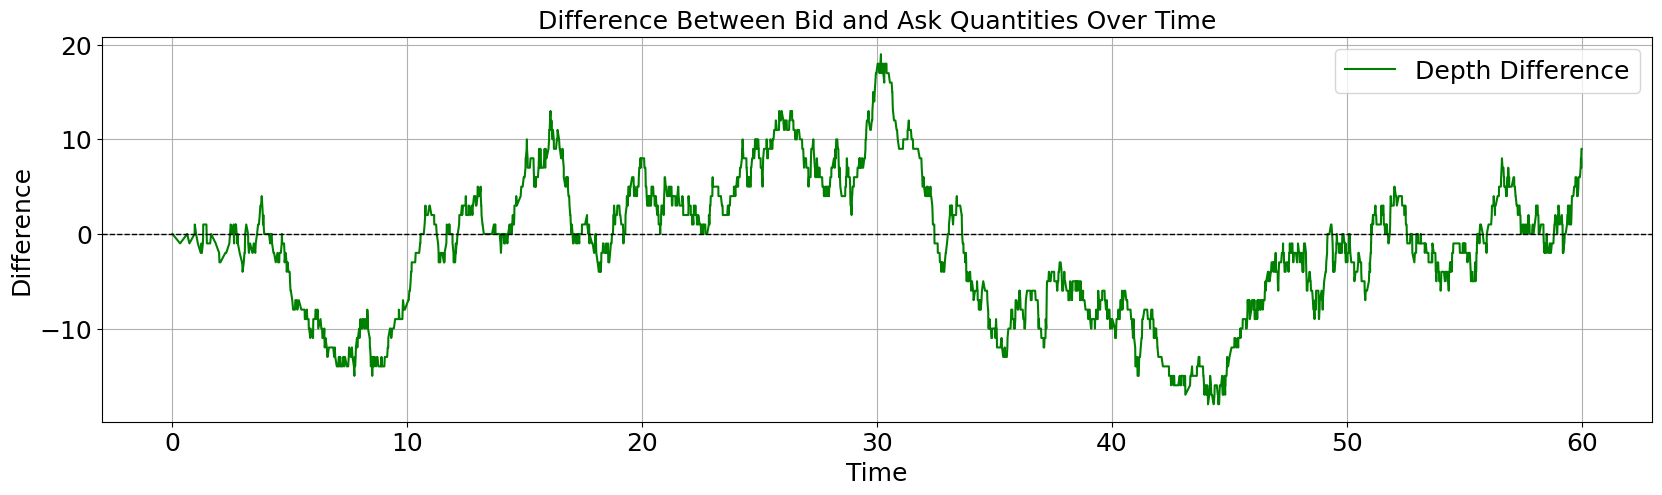

In [9]:
# Function to safely convert bid/ask quantities into lists of integers
def safe_convert_quantities(value):
    if isinstance(value, list):
        return value  # Already a list
    if isinstance(value, str):
        try:
            return [int(x) for x in value.split(',') if x.strip().isdigit()]
        except ValueError:
            return []
    return []

# Apply the safe conversion to the Bid and Ask Quantities columns
expanded_df["Bid Quantities"] = expanded_df["Bid Quantities"].apply(safe_convert_quantities)
expanded_df["Ask Quantities"] = expanded_df["Ask Quantities"].apply(safe_convert_quantities)

# Compute Bid and Ask Depth
expanded_df["Bid Depth"] = expanded_df["Bid Quantities"].apply(sum)
expanded_df["Ask Depth"] = expanded_df["Ask Quantities"].apply(sum)

#PLot the price evolution 
plt.figure(figsize=(20, 5))
plt.plot(tape_df['Time'], tape_df['Price'], label='Price', color='black')
plt.grid(True)
plt.title('Price Evolution Over Time')

# Plot the Bid and Ask Depth over Time
plt.figure(figsize=(20, 5))
plt.plot(expanded_df["Time"], expanded_df["Bid Depth"], marker="none", linestyle="-", label="Bid Quantities", color = 'blue')
plt.plot(expanded_df["Time"], expanded_df["Ask Depth"], marker="none", linestyle="-", label="Ask Quantities", color = 'red', markersize=3, linewidth=1)
plt.xlabel("Time")
plt.ylabel("Quantity")
plt.legend()
plt.grid()
plt.title("Limit Order Book Depth Over Time")
# Calculate the difference between Bid Depth and Ask Depth
expanded_df["Depth Difference"] = expanded_df["Bid Depth"] - expanded_df["Ask Depth"]

# Plot the Depth Difference over Time
plt.figure(figsize=(20, 5))
plt.plot(expanded_df["Time"], expanded_df["Depth Difference"], marker="none", linestyle="-", label="Depth Difference", color='green')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Baseline at y=0
plt.xlabel("Time")
plt.ylabel("Difference")
plt.title("Difference Between Bid and Ask Quantities Over Time")
plt.legend()
plt.grid()
plt.show()



In [10]:
def get_last_number(value):
    # If 'value' is a string like "110, 118", split on commas
    if isinstance(value, str):
        parts = value.split(',')
        # Strip whitespace from each part
        parts = [p.strip() for p in parts]
        # Convert the last part to an integer
        try:
            return int(parts[-1])
        except ValueError:
            return None
    return None

def get_last_number(value):
    # If 'value' is a string like "110, 118", split on commas
    if isinstance(value, str):
        parts = value.split(',')
        # Strip whitespace from each part
        parts = [p.strip() for p in parts]
        # Convert the last part to an integer
        try:
            return int(parts[0])
        except ValueError:
            return None
    return None

# Create a new column with the last number
expanded_df["Best Bid Price"] = expanded_df["Bid Prices"].apply(get_last_number)
expanded_df["Best Ask Price"] = expanded_df["Ask Prices"].apply(get_last_number)
expanded_df.head(5)

,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities,Bid Depth,Ask Depth,Depth Difference,Best Bid Price,Best Ask Price
0,0.000,0,,[],0,,[],0,0,0,NaN,NaN
1,0.325,0,,[],1,281,[1],0,1,-1,NaN,281.0
2,0.625,1,11,[1],1,281,[1],1,1,0,11.0,281.0
3,0.720,1,11,[1],2,"281, 367","[1, 1]",1,2,-1,11.0,281.0
4,0.940,2,"11, 148","[1, 1]",2,"281, 367","[1, 1]",2,2,0,11.0,281.0


Text(0, 0.5, 'Order Flow Imbalance')

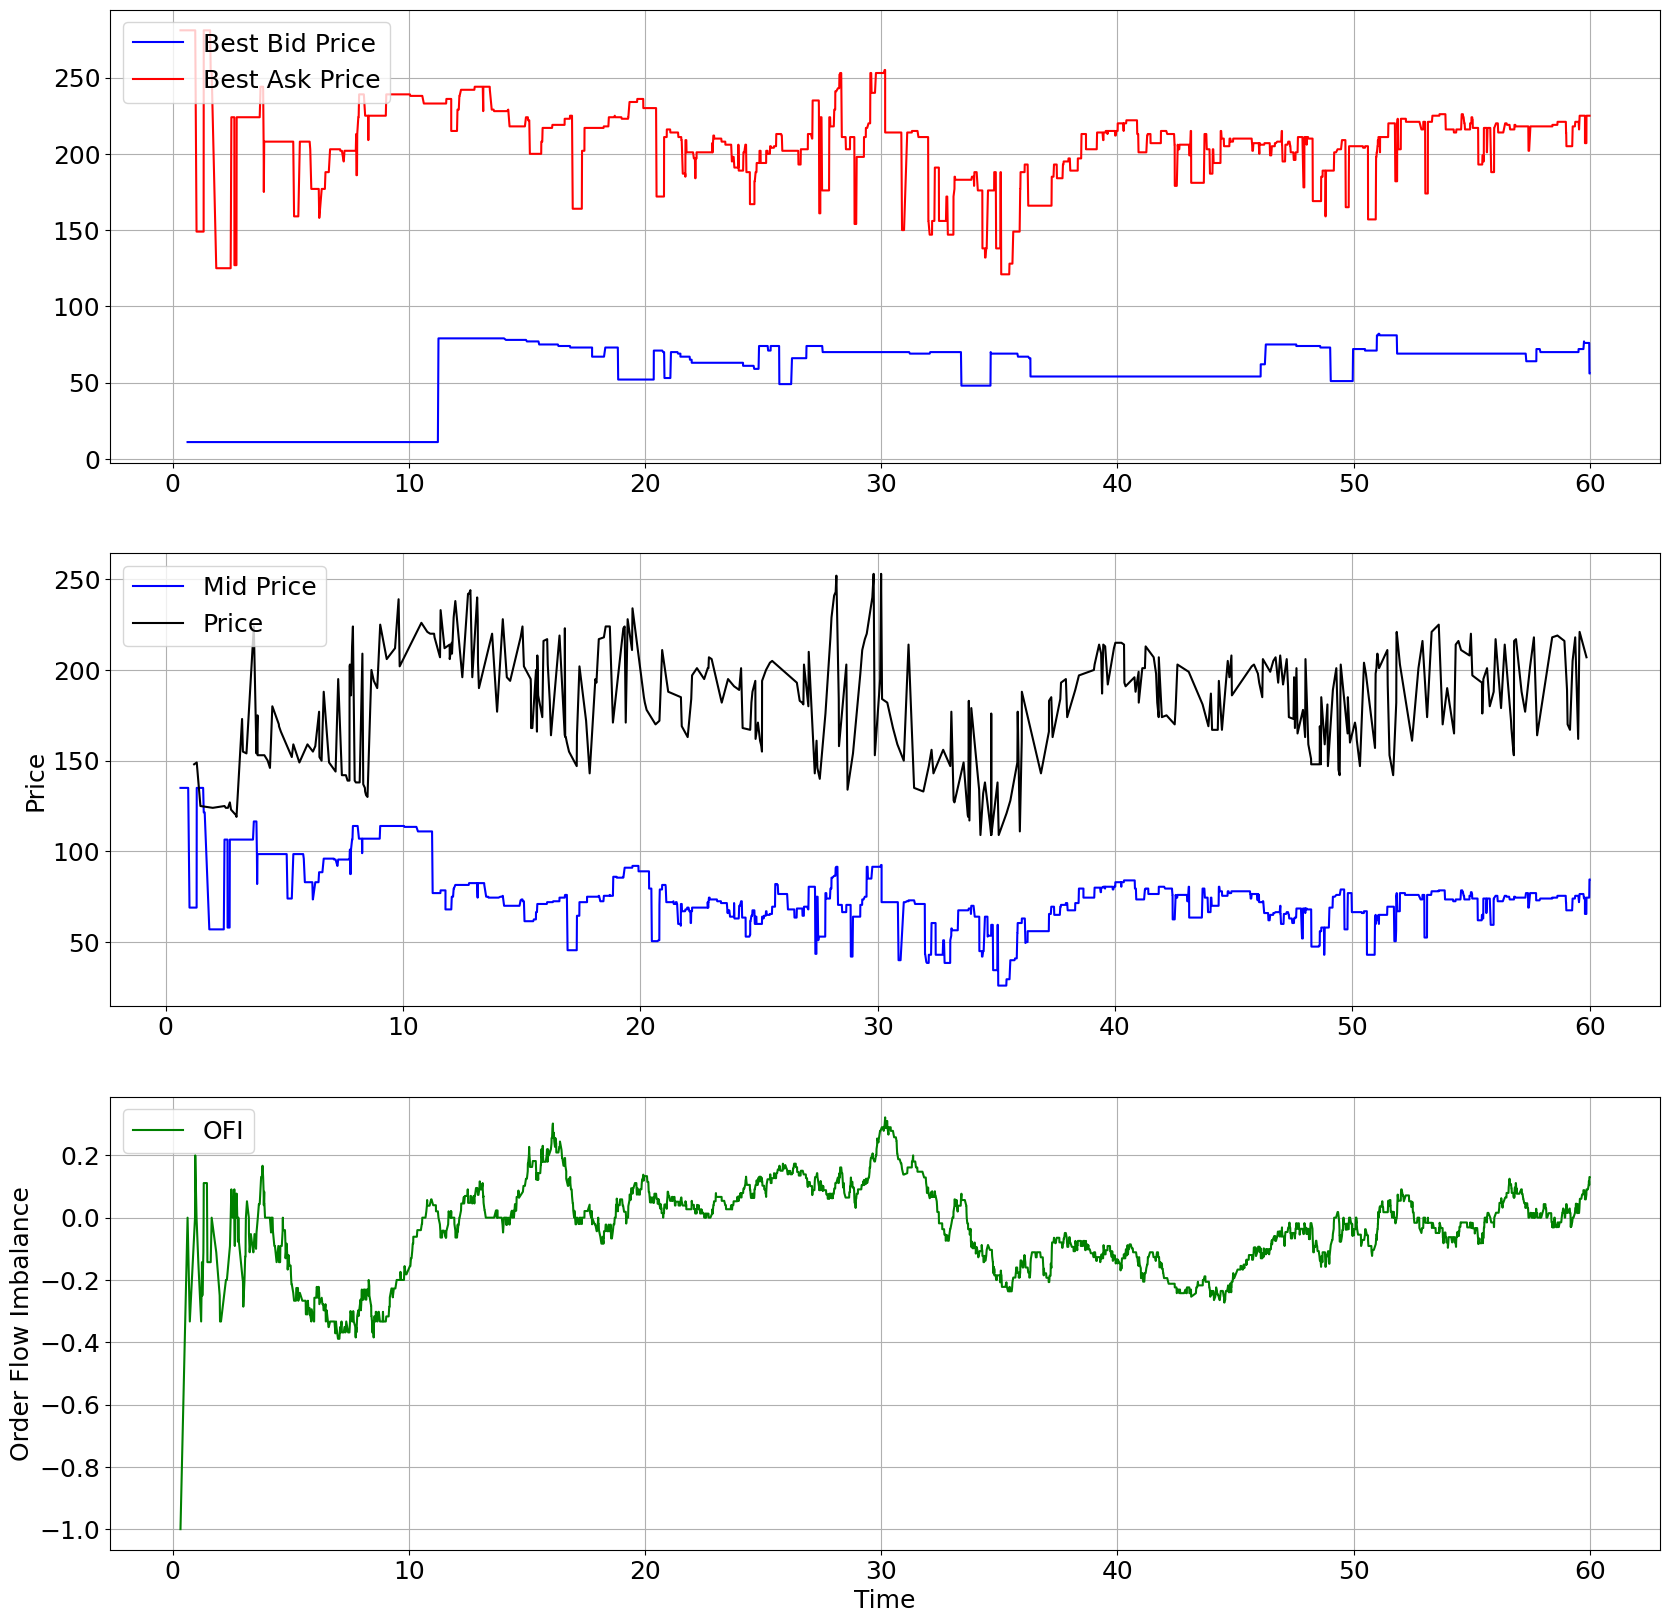

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
axs[0].plot(expanded_df["Time"], expanded_df["Best Bid Price"], label="Best Bid Price", color='blue')
axs[0].plot(expanded_df["Time"], expanded_df["Best Ask Price"], label="Best Ask Price", color='red')
axs[0].legend(loc = 'upper left')
axs[0].grid(True)

axs[1].plot(expanded_df["Time"], (expanded_df["Best Ask Price"] - expanded_df['Best Bid Price'])/2, color='blue', label='Mid Price')
axs[1].plot(tape_df['Time'], tape_df['Price'], color='black' , label='Price')
axs[1].legend(loc = 'upper left')
axs[1].set_ylabel('Price')
axs[1].grid(True)

axs[2].plot(expanded_df["Time"], expanded_df["Depth Difference"]/(expanded_df['Bid Depth'] + expanded_df['Ask Depth']), color='green', label='OFI')
axs[2].legend(loc = 'upper left')
axs[2].grid(True)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Order Flow Imbalance')

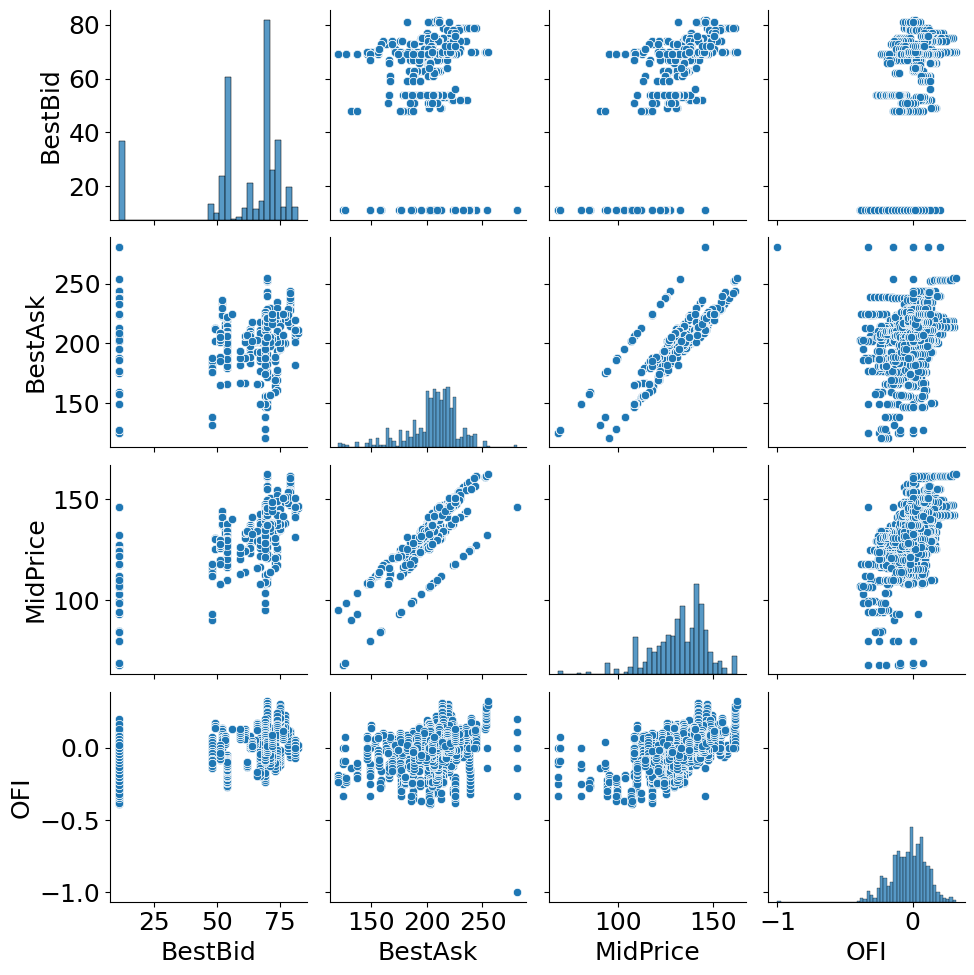

In [12]:
# 2. Create columns for pair plotting (if not already in your DataFrame)
expanded_df["Mid Price"] = (expanded_df["Best Ask Price"] + expanded_df["Best Bid Price"]) / 2
expanded_df["OFI"] = (expanded_df["Bid Depth"] - expanded_df["Ask Depth"]) / (expanded_df["Bid Depth"] + expanded_df["Ask Depth"])

# 3. Build a pairplot with Seaborn
#    Choose which columns to visualize
cols_for_pairplot = ["Best Bid Price", "Best Ask Price", "Mid Price", "OFI"]

# Optionally rename them for clarity in the plot
plot_df = expanded_df[cols_for_pairplot].rename(columns={
    "Best Bid Price": "BestBid",
    "Best Ask Price": "BestAsk",
    "Mid Price": "MidPrice"
})

# 4. Create the pairplot
sns.pairplot(plot_df, diag_kind="hist")
plt.show()


Correlation (OFI vs. future return): -0.024042543039402002
                            OLS Regression Results                            
Dep. Variable:          Return_future   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.715
Date:                Wed, 12 Mar 2025   Prob (F-statistic):              0.190
Time:                        09:10:27   Log-Likelihood:                 5452.4
No. Observations:                2967   AIC:                        -1.090e+04
Df Residuals:                    2965   BIC:                        -1.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

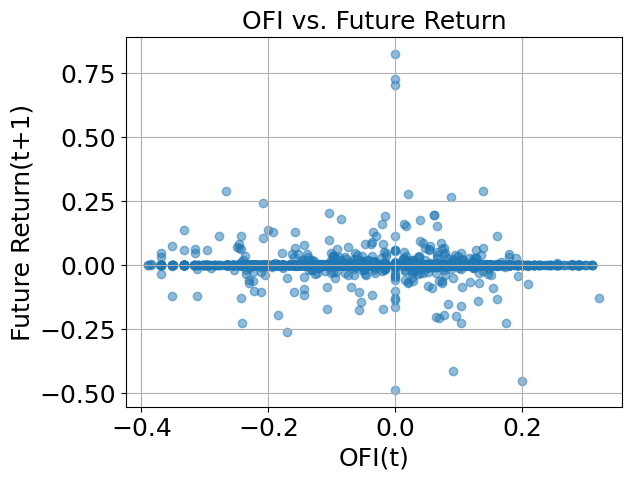

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assume df has columns: Time, MidPrice, OFI

shift_steps = 1  # define your time horizon
expanded_df["MidPrice_future"] = expanded_df["Mid Price"].shift(-shift_steps)
expanded_df["Return_future"] = (expanded_df["MidPrice_future"] - expanded_df["Mid Price"]) / expanded_df["Mid Price"]

expanded_df.dropna(inplace=True)

# Correlation
corr_value = expanded_df["OFI"].corr(expanded_df["Return_future"])
print("Correlation (OFI vs. future return):", corr_value)

# Simple linear regression
X = sm.add_constant(expanded_df["OFI"])  # add intercept
y = expanded_df["Return_future"]
model = sm.OLS(y, X).fit()
print(model.summary())

# Scatter plot
plt.scatter(expanded_df["OFI"], expanded_df["Return_future"], alpha=0.5)
plt.xlabel("OFI(t)")
plt.ylabel("Future Return(t+{})".format(shift_steps))
plt.title("OFI vs. Future Return")
plt.grid(True)
plt.show()


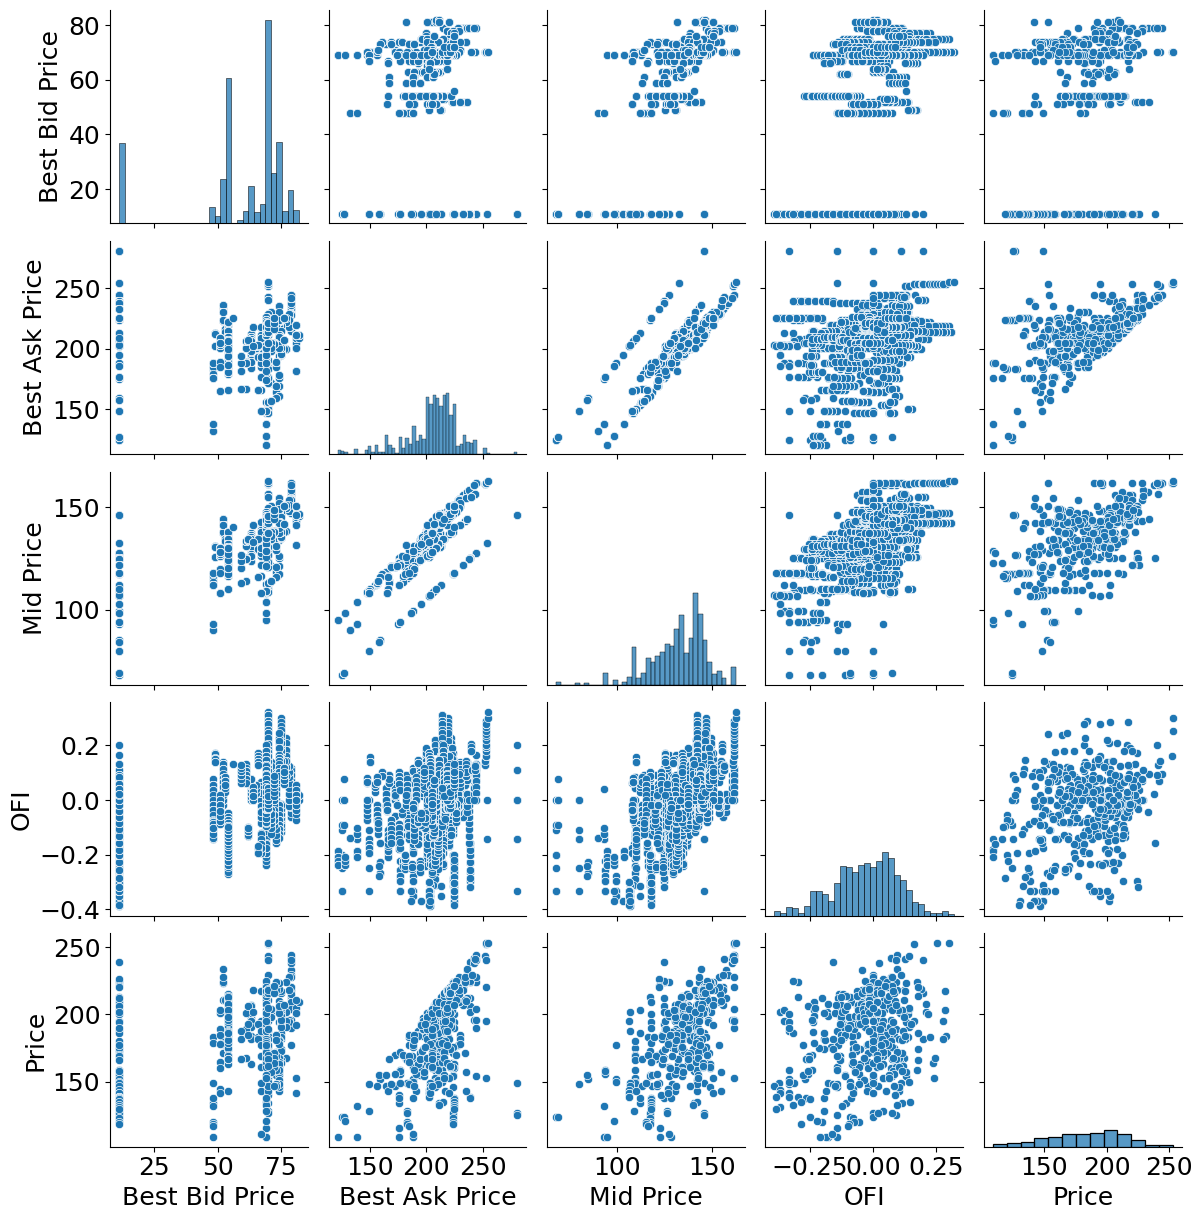

In [14]:
import pandas as pd

# 1. Sort both DataFrames by time
expanded_df.sort_values("Time", inplace=True)
tape_df.sort_values("Time", inplace=True)

merged_df = pd.merge(
    expanded_df,
    tape_df[["Time", "Price"]],  # only bring over the Time and Price columns
    on="Time",
    how="left"
)


# Now merged_df has columns from both expanded_df and tape_df
# including "Price" from tape_df and "Best Bid Price", "Best Ask Price", etc. from expanded_df.

# 3. Create your pairplot columns
cols_for_pairplot = [
    "Best Bid Price",
    "Best Ask Price",
    "Mid Price",
    "OFI",
    "Price"  # from tape_df
]

plot_df = merged_df[cols_for_pairplot]
sns.pairplot(plot_df)
plt.show()

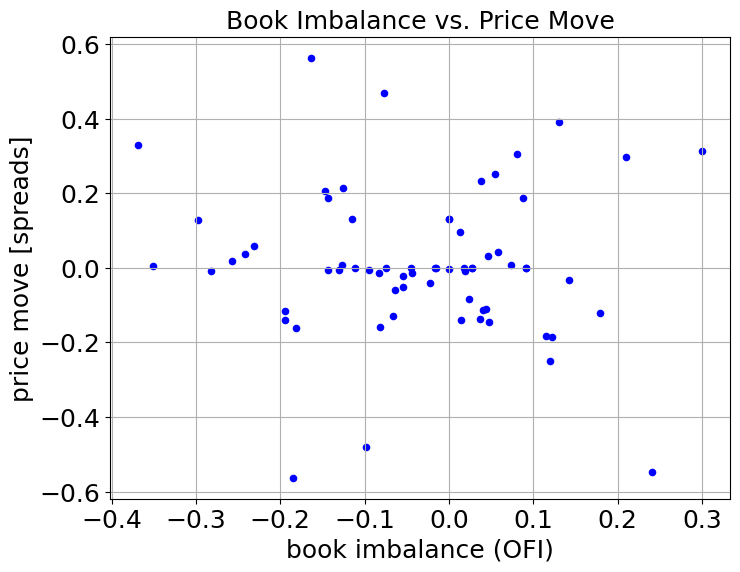

In [15]:
# 1. Suppose df has columns: "Time", "Price", "Best Bid Price", "Best Ask Price", "Bid Depth", "Ask Depth"

# Compute the spread
merged_df["Spread"] = merged_df["Best Ask Price"] - merged_df["Best Bid Price"]

# Compute Price Move in spread units
merged_df["Price Move (spreads)"] = merged_df["Price"].diff() / merged_df["Spread"]

# Compute OFI (book imbalance)
merged_df["OFI"] = (merged_df["Bid Depth"] - merged_df["Ask Depth"]) / (merged_df["Bid Depth"] + merged_df["Ask Depth"])

# Drop rows with any NaNs that might appear
merged_df.dropna(subset=["Price Move (spreads)", "OFI"], inplace=True)

# 2. Plot
plt.figure(figsize=(8,6))
plt.scatter(merged_df["OFI"], merged_df["Price Move (spreads)"], color='blue', s=20)

plt.xlabel("book imbalance (OFI)")
plt.ylabel("price move [spreads]")
plt.title("Book Imbalance vs. Price Move")
plt.grid(True)
plt.show()


/Users/joshcable/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/joshcable/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


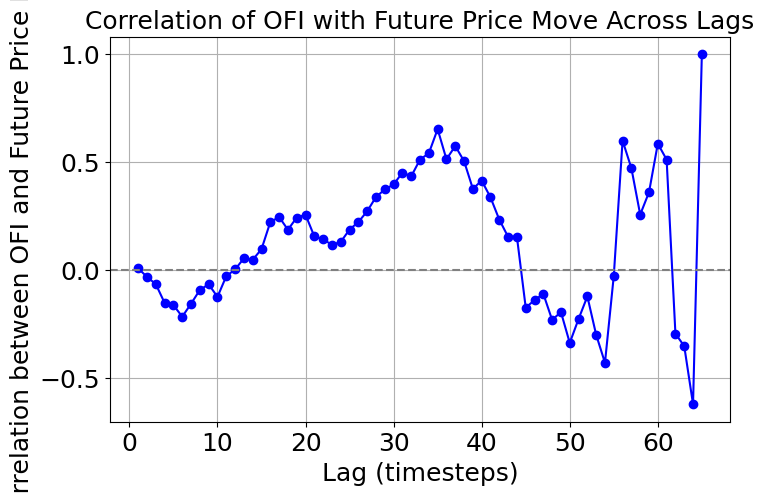

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a range of lags to test
lags = range(1, 100)  # Test lags from 1 to 20 timesteps

# Store correlations at each lag
lagged_correlations = []

for lag in lags:
    # Shift the price move column backwards to compare OFI at t with Price Move at t+lag
    merged_df[f"Price Move (spreads) lag{lag}"] = merged_df["Price"].diff(lag) / merged_df["Spread"]

    # Drop NaNs (these appear at the end of the dataset due to shifting)
    temp_df = merged_df.dropna(subset=[f"Price Move (spreads) lag{lag}", "OFI"])

    # Compute correlation between OFI and the lagged price move
    correlation = temp_df["OFI"].corr(temp_df[f"Price Move (spreads) lag{lag}"])
    lagged_correlations.append(correlation)

# Plot correlation vs. lag
plt.figure(figsize=(8, 5))
plt.plot(lags, lagged_correlations, marker="o", linestyle="-", color="blue")
plt.axhline(0, linestyle="--", color="gray")  # Reference line for zero correlation
plt.xlabel("Lag (timesteps)")
plt.ylabel("Correlation between OFI and Future Price Move")
plt.title("Correlation of OFI with Future Price Move Across Lags")
plt.grid(True)
plt.show()


----

In [17]:
def parse_price_string(price_str):
    """
    Given a string like '3,4,5,6', parse and return [3, 4, 5, 6] as integers.
    If the cell is empty or None, return an empty list.
    """
    if not price_str:  # handles None or empty
        return []
    # Split on commas and convert each piece to int
    return [int(p) for p in price_str.split(',') if p.strip().isdigit()]

# Parse the Bid Prices and Ask Prices columns into lists of integers
expanded_df['ParsedBidPrices'] = expanded_df['Bid Prices'].apply(parse_price_string)
expanded_df['ParsedAskPrices'] = expanded_df['Ask Prices'].apply(parse_price_string)

# Compute the highest bid and lowest ask at each timestamp
expanded_df['HighestBid'] = expanded_df['ParsedBidPrices'].apply(lambda prices: max(prices) if prices else None)
expanded_df['LowestAsk'] = expanded_df['ParsedAskPrices'].apply(lambda prices: min(prices) if prices else None)

# Display the resulting DataFrame with the new columns
expanded_df[['Time', 'HighestBid', 'LowestAsk']].head(5)

,Time,HighestBid,LowestAsk
2,0.625,11,281
3,0.720,11,281
4,0.940,148,281
5,0.950,148,281
6,1.005,148,149


In [18]:
expanded_df['MidPrice'] = 0.5 * (expanded_df['HighestBid'] + expanded_df['LowestAsk'])

In [19]:
# Initialize an empty list to store each trade as a dictionary
trades = []

# Variable to keep track of the current trader ID
current_trader = None

# Open and read the CSV file line by line
with open(volumes, 'r') as file:
    for line in file:
        parts = line.strip().split(', ')
        
        # Check if line indicates a new trader's trade count (e.g., "B00, 8")
        if len(parts) == 2 and parts[1].isdigit():
            current_trader = parts[0]  # Set the trader ID (e.g., "B00")
        
        # Check if line has enough parts to be a trade entry
        elif len(parts) >= 7:
            # Create a dictionary for each trade entry
            trade = {
                'TraderID': current_trader,
                'Type': parts[1],
                'Timestamp': float(parts[2]),
                'Price': int(parts[3]),
                'Seller': parts[4],
                'Buyer': parts[5],
                'Quantity': int(parts[6])
            }
            trades.append(trade)
        else:
            print(f"Skipping line due to unexpected format: {line}")

# Convert the list of trades to a DataFrame
blotters = pd.DataFrame(trades)

# Display the resulting DataFrame
blotters.head(5)

,TraderID,Type,Timestamp,Price,Seller,Buyer,Quantity
0,B00,Trade,4.770,170,B00,S47,1
1,B00,Trade,31.925,133,B00,S77,1
2,B00,Trade,35.990,111,B00,S35,1
3,B00,Trade,46.020,198,B00,S58,1
4,B00,Trade,53.640,225,S17,B00,1


In [20]:
# Sort the blotters DataFrame by the Timestamp column in ascending order
blotters_sorted = blotters.sort_values(by='Timestamp').reset_index(drop=True)

In [21]:
expanded_df['MidPrice'] = 0.5 * (expanded_df['HighestBid'] + expanded_df['LowestAsk'])
expanded_df['BuyDepth'] = blotters['Price'] - expanded_df['HighestBid']  
expanded_df['SellDepth'] = expanded_df['LowestAsk'] - blotters['Price']

expanded_df.head(2)

,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities,Bid Depth,Ask Depth,Depth Difference,...,OFI,MidPrice_future,Return_future,ParsedBidPrices,ParsedAskPrices,HighestBid,LowestAsk,MidPrice,BuyDepth,SellDepth
2,0.625,1,11,[1],1,281,[1],1,1,0,...,0.000000,146.0,0.0,[11],[281],11,281,146.0,100.0,170.0
3,0.720,1,11,[1],2,"281, 367","[1, 1]",1,2,-1,...,-0.333333,146.0,0.0,[11],"[281, 367]",11,281,146.0,187.0,83.0


In [22]:
# Merge trades with order book data using Timestamp
merged_df = expanded_df.merge(blotters_sorted, left_on='Time', right_on='Timestamp', how='left')

# Fill NaN values (if no trade occurred at a specific order book update, assume 0 market orders)
merged_df['Quantity'] = merged_df['Quantity'].fillna(0)

merged_df.head(2)


,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities,Bid Depth,Ask Depth,Depth Difference,...,MidPrice,BuyDepth,SellDepth,TraderID,Type,Timestamp,Price,Seller,Buyer,Quantity
0,0.625,1,11,[1],1,281,[1],1,1,0,...,146.0,100.0,170.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0.720,1,11,[1],2,"281, 367","[1, 1]",1,2,-1,...,146.0,187.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


<Figure size 1600x500 with 0 Axes>

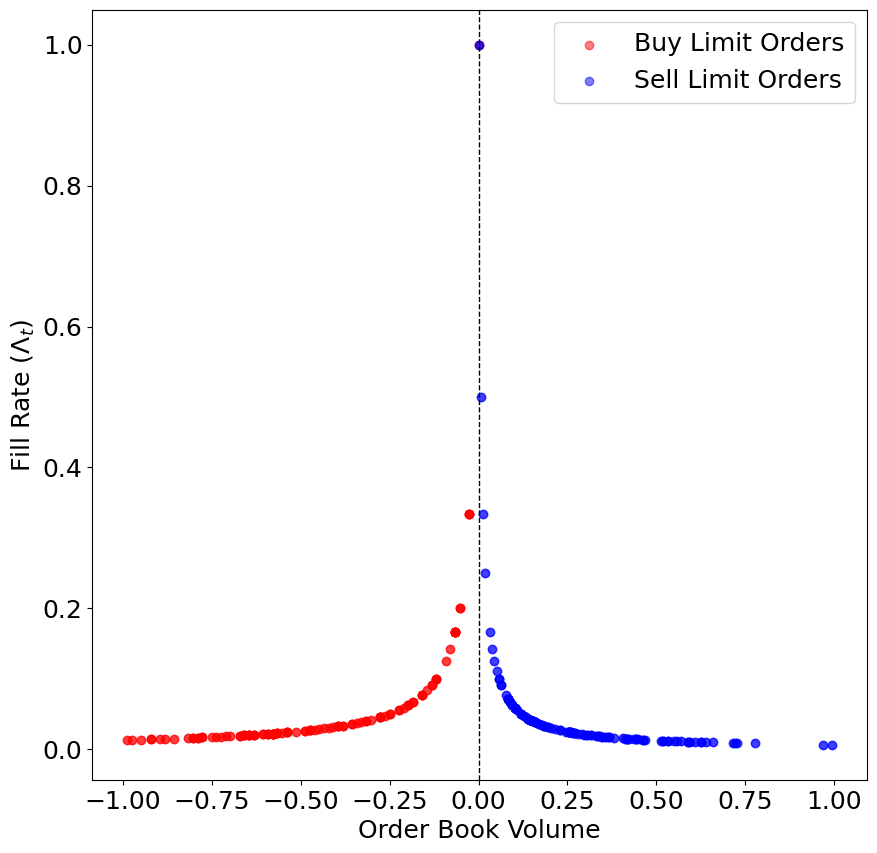

In [23]:
# Replace zero or negative depths with NaN to avoid divide-by-zero errors
merged_df.loc[merged_df['BuyDepth'] <= 0, 'BuyDepth'] = None
merged_df.loc[merged_df['SellDepth'] <= 0, 'SellDepth'] = None

# Compute Fill Rates
merged_df['FillRate_Buy'] = merged_df['Quantity'] / merged_df['BuyDepth']
merged_df['FillRate_Sell'] = merged_df['Quantity'] / merged_df['SellDepth']

# Fill NaN values (if depth was 0, assume no liquidity to fill)
merged_df[['FillRate_Buy', 'FillRate_Sell']] = merged_df[['FillRate_Buy', 'FillRate_Sell']].fillna(0)

# Compute Fill Rates
#merged_df['FillRate_Buy'] = merged_df['Quantity'] / merged_df['BuyDepth']
#merged_df['FillRate_Sell'] = merged_df['Quantity'] / merged_df['SellDepth']

# Fill NaN values (if depth was 0, assume no liquidity was filled)
#merged_df[['FillRate_Buy', 'FillRate_Sell']] = merged_df[['FillRate_Buy', 'FillRate_Sell']].fillna(0)

# Ensure merged_df exists before proceeding
plt.figure(figsize=(16, 5))
if 'merged_df' in locals() or 'merged_df' in globals():
    plt.figure(figsize=(10, 10))

    # Filter out zero fill rates
    buy_fill_data = merged_df[merged_df['FillRate_Buy'] > 0].copy()
    sell_fill_data = merged_df[merged_df['FillRate_Sell'] > 0].copy()

    # FIX: Reverse Buy Depth Normalization so that smaller depths are closer to 0
    buy_fill_data['Normalized_BuyDepth'] = -1 * ((buy_fill_data['BuyDepth'] - buy_fill_data['BuyDepth'].min())/ buy_fill_data['BuyDepth'].max())

    # Sell Depth remains the same (0 to 1)
    sell_fill_data['Normalized_SellDepth'] = ((sell_fill_data['SellDepth'] - sell_fill_data['SellDepth'].min()) / sell_fill_data['SellDepth'].max() )

    # Scatter plot of Normalized Fill Rate vs Depth
    plt.scatter(buy_fill_data['Normalized_BuyDepth'], buy_fill_data['FillRate_Buy'], color='red', alpha=0.5, label='Buy Limit Orders')
    plt.scatter(sell_fill_data['Normalized_SellDepth'], sell_fill_data['FillRate_Sell'], color='blue', alpha=0.5, label='Sell Limit Orders')

    # Labels and Title
    plt.xlabel("Order Book Volume")
    plt.ylabel("Fill Rate ($\Lambda_t$)")
    #plt.title("Fill Rate vs Normalized Depth (Buy: 0 to -1, Sell: 0 to 1)")
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)  # Midpoint (spread)
    plt.legend()

    # Show plot
    plt.show()
else:
    print("Error: merged_df is not defined. Please reload your data and recompute the fill rates.")


In [24]:
import numpy as np
import pandas as pd

# Example: if you have a single column "Price" for the limit order, and "MidPrice" for the mid.
merged_df["Distance"] = (merged_df["Price"] - merged_df["MidPrice"]).abs()
merged_df["FillRate"] = merged_df["Quantity"] / merged_df["Distance"]



In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. If you don't already have a 'MidPrice' column:
merged_df["MidPrice"] = (merged_df["Best Ask Price"] + merged_df["Best Bid Price"]) / 2

# 2. Define distance from mid-price for the best bid and best ask
#    Typically:
#      Distance_Bid = MidPrice - BestBid  (should be >= 0 if ask >= bid)
#      Distance_Ask = BestAsk - MidPrice
merged_df["Distance_Bid"] = merged_df["MidPrice"] - merged_df["Best Bid Price"]
merged_df["Distance_Ask"] = merged_df["Best Ask Price"] - merged_df["MidPrice"]

# 3. Compute fill rates for each side
#    For example, if 'Bid Depth' is the total liquidity at the best bid,
#    and 'Bid Total Quantity' is the size of the filled order (or partial fill).
#    Adjust these columns to match your dataset.
merged_df["FillRate_Bid"] = merged_df["Bid Total Quantity"] / merged_df["Bid Depth"]
merged_df["FillRate_Ask"] = merged_df["Ask Total Quantity"] / merged_df["Ask Depth"]

# 4. Replace invalid or zero depths with NaN, then drop them
merged_df.loc[merged_df["Bid Depth"] <= 0, "FillRate_Bid"] = np.nan
merged_df.loc[merged_df["Ask Depth"] <= 0, "FillRate_Ask"] = np.nan

merged_df.head(10)

,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities,Bid Depth,Ask Depth,Depth Difference,...,Buyer,Quantity,FillRate_Buy,FillRate_Sell,Distance,FillRate,Distance_Bid,Distance_Ask,FillRate_Bid,FillRate_Ask
0,0.625,1,11,[1],1,281,[1],1,1,0,...,NaN,0.0,0.000000,0.0,NaN,NaN,135.0,135.0,1.0,1.0
1,0.720,1,11,[1],2,"281, 367","[1, 1]",1,2,-1,...,NaN,0.0,0.000000,0.0,NaN,NaN,135.0,135.0,1.0,1.0
2,0.940,2,"11, 148","[1, 1]",2,"281, 367","[1, 1]",2,2,0,...,NaN,0.0,0.000000,0.0,NaN,NaN,135.0,135.0,1.0,1.0
3,0.950,3,"11, 123, 148","[1, 1, 1]",2,"281, 367","[1, 1]",3,2,1,...,NaN,0.0,0.000000,0.0,NaN,NaN,135.0,135.0,1.0,1.0
4,1.005,3,"11, 123, 148","[1, 1, 1]",3,"149, 281, 367","[1, 1, 1]",3,3,0,...,NaN,0.0,0.000000,0.0,NaN,NaN,69.0,69.0,1.0,1.0
5,1.080,3,"11, 123, 148","[1, 1, 1]",4,"149, 281, 290, 367","[1, 1, 1, 1]",3,4,-1,...,NaN,0.0,0.000000,0.0,NaN,NaN,69.0,69.0,1.0,1.0
6,1.200,2,"11, 123","[1, 1]",4,"149, 281, 290, 367","[1, 1, 1, 1]",2,4,-2,...,S08,1.0,0.019608,0.0,12.0,0.083333,69.0,69.0,1.0,1.0
7,1.200,2,"11, 123","[1, 1]",4,"149, 281, 290, 367","[1, 1, 1, 1]",2,4,-2,...,S08,1.0,0.019608,0.0,12.0,0.083333,69.0,69.0,1.0,1.0
8,1.235,3,"11, 123, 124","[1, 1, 1]",4,"149, 281, 290, 367","[1, 1, 1, 1]",3,4,-1,...,NaN,0.0,0.000000,0.0,NaN,NaN,69.0,69.0,1.0,1.0
9,1.250,3,"11, 123, 124","[1, 1, 1]",5,"149, 281, 290, 367, 384","[1, 1, 1, 1, 1]",3,5,-2,...,NaN,0.0,0.000000,0.0,NaN,NaN,69.0,69.0,1.0,1.0


In [ ]:
plt.figure(figsize=(20, 10))

# Scatter plot for best bid
plt.scatter(plot_df["Distance_Bid"], plot_df["FillRate_Bid"],
            color='red', alpha=0.5, label='Best Bid')

# Scatter plot for best ask
plt.scatter(plot_df["Distance_Ask"], plot_df["FillRate_Ask"],
            color='blue', alpha=0.5, label='Best Ask')

plt.xlabel("Distance from Mid-Price")
plt.ylabel("Fill Rate")
plt.title("Fill Rate vs. Distance from Mid-Price for Best Bid/Ask")
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'Distance_Bid'

<Figure size 2000x1000 with 0 Axes>